[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/khetansarvesh/CV/blob/main/data_augmentation/ae/ae_transformer.ipynb)


In [12]:
import torch
import cv2
import torchvision
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from torch.optim import Adam
from matplotlib import pyplot as plt
from einops import rearrange, repeat

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# **Dataset**

In [3]:
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

In [19]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) # Define the transformation to normalize the data between 1 and -1 (mean = 0.5 and variance = 0.5 will transform to values between 1 and -1)
mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True) # downloading the MNIST train dataset and then applying some transformations
mnist_loader = DataLoader(dataset=mnist, batch_size=32, shuffle=True, num_workers=0) # loading the downloaded dataset

In [24]:
# train_features_batch, train_labels_batch = next(iter(mnist_loader))
# print(f"Features Batch Size {train_features_batch.shape}")

Features Batch Size torch.Size([32, 1, 28, 28])


# **Modelling**

In [42]:
class ae_transformers(nn.Module):

    def __init__(self):
        super().__init__()

        self.patch_embedding = nn.Sequential(nn.LayerNorm(1*4*4), nn.Linear(1*4*4, 768), nn.LayerNorm(768))
        self.position_embedding = nn.Parameter(data=torch.randn(1, 49, 768),requires_grad=True)
        self.embedding_dropout = nn.Dropout(p=0.1)

        self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=768,
                                                                                                  nhead=2,
                                                                                                  dim_feedforward=3072,
                                                                                                  activation="gelu",
                                                                                                  batch_first=True,
                                                                                                  norm_first=True), # Create a single Transformer Encoder Layer
                                                        num_layers=2) # Stack it N times

        # Final Linear Layer
        self.proj_out = nn.Linear(768, 1*4*4)


    def forward(self, x):

        # 32, 1, 28, 28 -> 32, 1, 7*4, 7*4 -> 32, 1, 7, 7, 4, 4 -> 32, 7, 7, 4, 4, 1 -> 32, 7*7, 4*4*1 - > 32, num_patches, patch_dim
        x = rearrange(x, 'b c (nh ph) (nw pw) -> b (nh nw) (ph pw c)', ph=4, pw=4)

        # Create patch embedding for all images in the batch
        x = self.patch_embedding(x)

        #Add position embedding to patch embedding
        x = self.position_embedding + x

        #Run embedding dropout
        x = self.embedding_dropout(x)

        #Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # Unpatchify i.e. (B,patches,hidden_size) -> (B,patches,channels * patch_width * patch_height)
        x = self.proj_out(x)

        # combine all the patches to form image
        x = rearrange(x, 'b (nh nw) (ph pw c) -> b c (nh ph) (nw pw)',ph=4,pw=4,nw=7,nh=7)
        return x

# **Training**

In [43]:
model = ae_transformers().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [66]:
for epoch_idx in range(20): # Run training for 10 epochs

    losses = []

    for im, _ in tqdm(mnist_loader):

        im = im.float().to(device)

        optimizer.zero_grad()

        # passing to model
        out = model(im)

        # loss calculation
        loss = nn.MSELoss()(im, out)

        # housekeeping
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

    print(f'''Finished epoch:{epoch_idx+1} | KL Loss : {np.mean(losses)} ''')

100%|██████████| 1875/1875 [01:23<00:00, 22.36it/s]


Finished epoch:1 | KL Loss : 0.23212074542045594 


100%|██████████| 1875/1875 [01:24<00:00, 22.12it/s]


Finished epoch:2 | KL Loss : 18.660408070154986 


100%|██████████| 1875/1875 [01:24<00:00, 22.17it/s]


Finished epoch:3 | KL Loss : 0.44818748030662536 


100%|██████████| 1875/1875 [01:24<00:00, 22.14it/s]


Finished epoch:4 | KL Loss : 0.25361004378795626 


100%|██████████| 1875/1875 [01:24<00:00, 22.14it/s]


Finished epoch:5 | KL Loss : 0.1774192709048589 


100%|██████████| 1875/1875 [01:24<00:00, 22.11it/s]


Finished epoch:6 | KL Loss : 0.1382043998360634 


100%|██████████| 1875/1875 [01:25<00:00, 22.05it/s]


Finished epoch:7 | KL Loss : 0.09962351829608282 


100%|██████████| 1875/1875 [01:25<00:00, 21.94it/s]


Finished epoch:8 | KL Loss : 0.05579176397025585 


100%|██████████| 1875/1875 [01:25<00:00, 21.84it/s]


Finished epoch:9 | KL Loss : 5.530329963851472 


100%|██████████| 1875/1875 [01:25<00:00, 21.94it/s]


Finished epoch:10 | KL Loss : 0.24588355423212052 


100%|██████████| 1875/1875 [01:25<00:00, 21.85it/s]


Finished epoch:11 | KL Loss : 0.11432180963754654 


100%|██████████| 1875/1875 [01:25<00:00, 21.96it/s]


Finished epoch:12 | KL Loss : 0.08833944200277329 


100%|██████████| 1875/1875 [01:25<00:00, 21.94it/s]


Finished epoch:13 | KL Loss : 0.06455443098545074 


100%|██████████| 1875/1875 [01:25<00:00, 21.89it/s]


Finished epoch:14 | KL Loss : 0.03835808983246485 


100%|██████████| 1875/1875 [01:25<00:00, 21.83it/s]


Finished epoch:15 | KL Loss : 0.019481863217552502 


100%|██████████| 1875/1875 [01:26<00:00, 21.79it/s]


Finished epoch:16 | KL Loss : 0.012392533358683188 


100%|██████████| 1875/1875 [01:25<00:00, 21.93it/s]


Finished epoch:17 | KL Loss : 8.639286024685203 


100%|██████████| 1875/1875 [01:25<00:00, 22.02it/s]


Finished epoch:18 | KL Loss : 0.16037123091220856 


100%|██████████| 1875/1875 [01:25<00:00, 21.97it/s]


Finished epoch:19 | KL Loss : 0.1080548975666364 


100%|██████████| 1875/1875 [01:25<00:00, 21.95it/s]

Finished epoch:20 | KL Loss : 0.07281601288517316 


# **Inference**

In [67]:
# Getting 10 random indexes
idxs = torch.randint(0, len(mnist)-1, (10, ))

# using these indexes to get images from mnist dataset and concatenating them
test_ims = torch.cat([mnist[idx][0][None, :] for idx in idxs]).float()

# generating images for the above test dataset
generated_im = model(test_ims.to(device))

In [68]:
generated_im = torch.clamp(generated_im, -1., 1.).detach().cpu() # clamping the generated images
generated_im = 0.5*generated_im + 0.5 #detransforming the images from [-1,1] to [0,1]

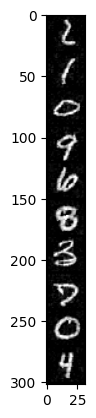

In [69]:
# now printing the predicted images
grid = torchvision.utils.make_grid(generated_im, nrow=1)
img = torchvision.transforms.ToPILImage()(grid)
plt.imshow(img, cmap='gray')